In [1]:
import cv2
import matplotlib.pyplot as plt

In [2]:
def display_image(img):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')

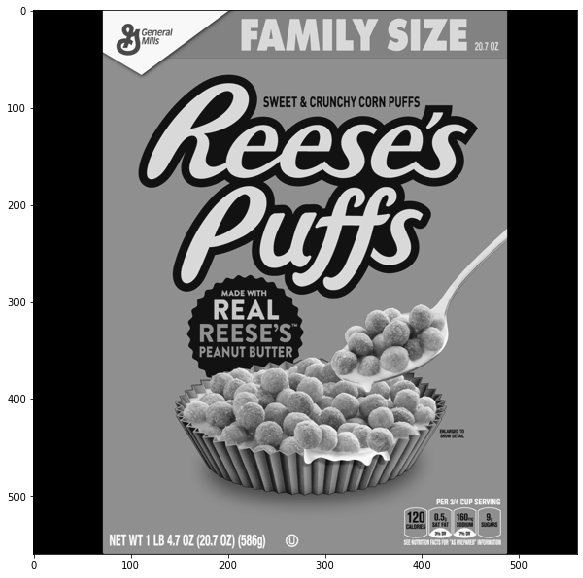

In [3]:
reeses = cv2.imread('../../notebooks/DATA/reeses_puffs.png', 0)
display_image(reeses)

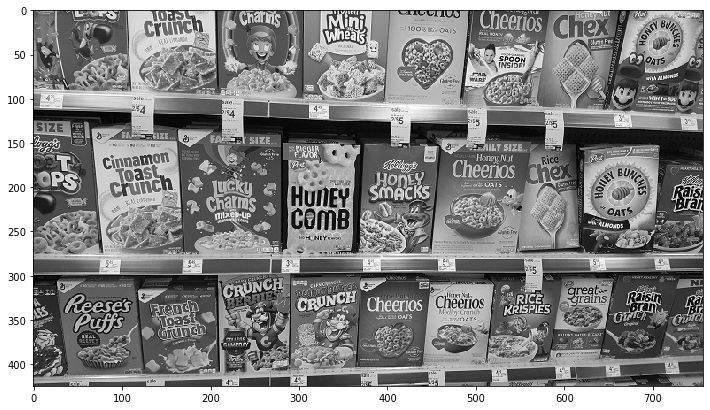

In [4]:
cereal = cv2.imread('../../notebooks/DATA/many_cereals.jpg', 0)
display_image(cereal)

In [18]:
'''
# #################################################################################################
#  BRUTE FORCE MATCHING WITH ORB DESCRIPTORS - Not much good.
# #################################################################################################
'''
orb = cv2.ORB_create()
key_points1, description1 = orb.detectAndCompute(image=reeses, mask=None)
key_points2, description2 = orb.detectAndCompute(image=cereal, mask=None)

In [19]:
brute_force = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

In [22]:
matches = brute_force.match(description1, description2)

In [25]:
# Just looking at a single match instance.
single_match = matches[0]
# This 'distance' value essentially indicate how good the match is. If the distance is large,
# the match is weak, if the distance is small, it's good match.
single_match.distance


78.0

In [29]:
# Sort 'matches' respective to their distance.
matches = sorted(matches, key=lambda m: m.distance)

In [30]:
reeses_match = cv2.drawMatches(img1=reeses,
                               keypoints1=key_points1,
                               img2=cereal,
                               keypoints2=key_points2,
                               matches1to2=matches[:25],
                               outImg=None,
                               flags=0)

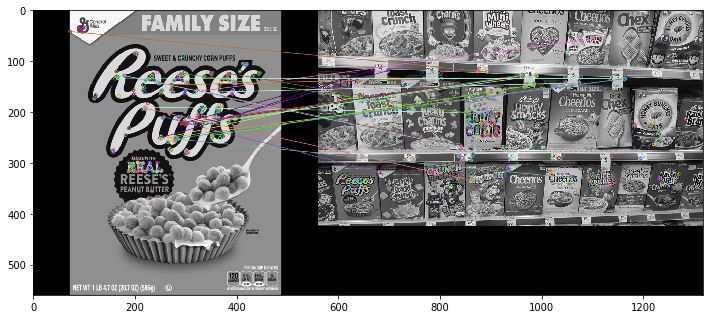

In [31]:
display_image(reeses_match)

In [57]:
'''
# #################################################################################################
#  BRUTE FORCE MATCHING WITH SIFT DESCRIPTORS - SCALE INVARIANT FEATURE TRANSFORM (SIFT)
#                                               and RATIO TEST
# #################################################################################################
'''
sift = cv2.xfeatures2d.SIFT_create()
key_points1, description1 = sift.detectAndCompute(image=reeses, mask=None)
key_points2, description2 = sift.detectAndCompute(image=cereal, mask=None)

In [58]:
brute_force = cv2.BFMatcher()

In [59]:
# By 'k' parameter we define, how many top matches we need from each descriptors.
matches = brute_force.knnMatch(queryDescriptors=description1,
                               trainDescriptors=description2,
                               k=2)

# This is list of pairs which 0th indexed value is best match and 1st index value
# is second best match. The pair size limited by the 'k' parameter define above.
matches[:2]

[[<DMatch 000001F8C7444890>, <DMatch 000001F8C74449D0>],
 [<DMatch 000001F8C7444A30>, <DMatch 000001F8C74443D0>]]

In [69]:
good = []

# LESS DISTANCE == BETTER MATCH
# RATIO MATCH < 75% of MATCH2
for match1, match2 in matches:
    # IF MATCH 1 DISTANCE IS LESS THAN 75% of MATCH 2 DISTANCE, THEN
    # THAT'S A GOOD MATCH. LET'S KEEP IT.
    if match1.distance < match2.distance * 0.75:
        good.append([match1])

In [70]:
# This number of matches we've discarded (bad matches).
len(matches) - len(good)

1422

In [71]:
# 'cv2.drawMatchesKnn' expects list of lists as matches.
sift_matches = cv2.drawMatchesKnn(img1=reeses,
                                  keypoints1=key_points1,
                                  img2=cereal,
                                  keypoints2=key_points2,
                                  matches1to2=good,
                                  outImg=None,
                                  flags=2)

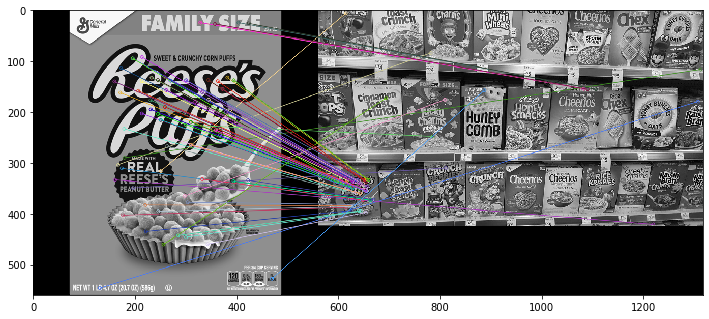

In [72]:
display_image(sift_matches)

In [5]:
'''
# #################################################################################################
#  FLANN BASED MATCHER - FAST LIBRARY for APPROXIMATE NEAREST NEIGHBORS
# #################################################################################################
'''

sift = cv2.xfeatures2d.SIFT_create()

key_points1, description1 = sift.detectAndCompute(image=reeses, mask=None)
key_points2, description2 = sift.detectAndCompute(image=cereal, mask=None)

In [6]:
# FLANN PARAMETERS.
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, tree=5)
search_params = dict(checks=50)

In [7]:
flann = cv2.FlannBasedMatcher(index_params, search_params)

In [8]:
matches = flann.knnMatch(queryDescriptors=description1, trainDescriptors=description2, k=2)

In [9]:
# RATIO TEST.
good = []

for match1, match2 in matches:

    if match1.distance < match2.distance * .75:
        good.append([match1])

In [10]:
# If the 'flag=0', it shows all the matches, but draw lines only to matching ones.
# If the 'flag=2', it only show and draw lines to best matching features.
flann_matches = cv2.drawMatchesKnn(img1=reeses,
                                   keypoints1=key_points1,
                                   img2=cereal,
                                   keypoints2=key_points2,
                                   matches1to2=good,
                                   outImg=None,
                                   flags=0)

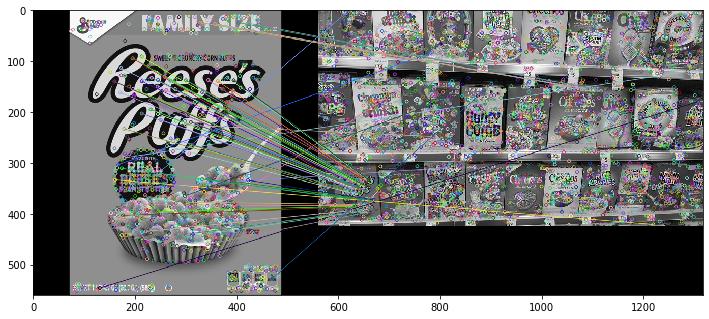

In [11]:
display_image(flann_matches)

In [17]:
'''
 DIFFERENTIATE GOOD AND BAD MATCHED BY A COLOR
'''

matchMask = [[0, 0] for i in range(len(matches))]
matchMask[:10]

[[0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0]]

In [18]:
# RATIO TEST - MODIFIED (Do not filter out bad matches, instead, mark them in a different color.)
for i, (match1, match2) in enumerate(matches):

    if match1.distance < match2.distance * 0.75:
        matchMask[i] = [1, 0]

In [21]:
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchMask,
                   flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)

In [22]:
flann_matches = cv2.drawMatchesKnn(reeses,
                                   key_points1,
                                   cereal,
                                   key_points2,
                                   matches,
                                   None,
                                   **draw_params)

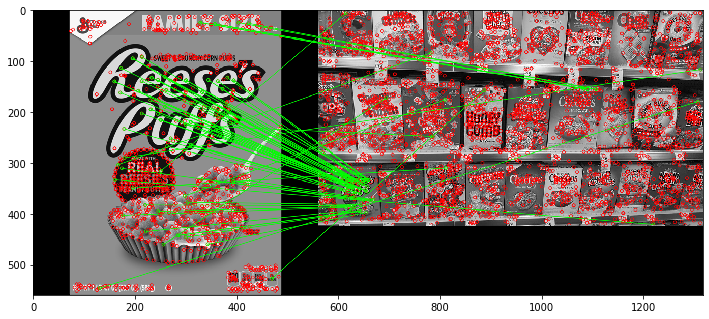

In [23]:
display_image(flann_matches)